# Visualize Results of Reconstruction

This notebook can be used for visualizing (Mainly 3D) the results of reconstructions.

This notebook if for new (as of August results format).

In [47]:
%matplotlib inline
import cPickle
import cv2
import matplotlib
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)
font = dict(weight="normal", size=16)
matplotlib.rc('font', **font)
import math
import mayavi.mlab as mlab
import numpy as np
import os
import pymap3d
import scipy.io as sio
import tqdm
from tvtk.tools import visual

## Load Results

In [51]:
with open("results/export_data_0930.pkl", 'rb') as f:
    export_data = cPickle.load(f)
grid = sio.loadmat("results/grid.mat")
xgrid, ygrid, zgrid = grid["X"].flatten(), grid["Y"].flatten(), -grid["Z"].flatten()[::-1]

In [55]:
#with open("results/beta_0830_zero_init.pkl", 'rb') as f:
#    beta = cPickle.load(f)
with open("results/beta_0930_lidar_init.pkl", 'rb') as f:
    beta = cPickle.load(f)

In [53]:
extra_data = export_data["109L"]["extra_data"]
sun_az, sun_mu = extra_data["sun_az"], extra_data["sun_mu"]

## Visualize Beta 

The SHDOM conventions is the beta axes are XYZ where X points to the North and Y to the East (and Z up). This makes a left hand system. Mayavi uses right hand system. Therefore there is a need to transpose the XY directions of beta and also of the camera center locations.

In the visualization, X points to the East and Y to the North.

In [25]:
def viz3D(data, xgrid, ygrid, zgrid, export_data=None):
    """Visualize reconstructed Beta.
    
    Note:
    The SHDOM conventions is the beta axes are XYZ where X points to the North
    and Y to the East (and Z up). This makes a left hand system. Mayavi uses
    right hand system. Therefore there is a need to transpose the XY directions
    of beta and also of the camera center locations.
    In the visualization, X points to the East and Y to the North.
    """
    #mlab.figure(size=(12, 12))
    
    X, Y, Z = np.meshgrid(xgrid, ygrid, zgrid, indexing='ij')
    src = mlab.pipeline.scalar_field(X, Y, Z, np.transpose(data, (1, 0, 2)))

    src.update_image_data = True
    ipw_x = mlab.pipeline.image_plane_widget(src, plane_orientation='x_axes')
    ipw_y = mlab.pipeline.image_plane_widget(src, plane_orientation='y_axes')
    ipw_z = mlab.pipeline.image_plane_widget(src, plane_orientation='z_axes')
    
    colorbar = mlab.colorbar(title=r'Extinction [1/km]', orientation='vertical', label_fmt = '%.2f')
    mlab.outline()

    if export_data is None:
        return
    
    for camera_id, data in export_data.items():
        x = data["extra_data"]["x"]
        y = data["extra_data"]["y"]
        z = data["extra_data"]["z"]

        #
        # Draw a point at the camera center.
        #
        mlab.points3d(
            [y], [x], [z],
            color=(1, 0, 0), mode='sphere', scale_mode='scalar', scale_factor=200,
        )

        mlab.text3d(y, x, z+0.2, camera_id, color=(0, 0, 0), scale=200)
        
    return ipw_x, ipw_y, ipw_z

In [26]:
viz3D(beta, xgrid, ygrid, zgrid, export_data)
mlab.show()

## Visualize Profile

(0, 0.14)

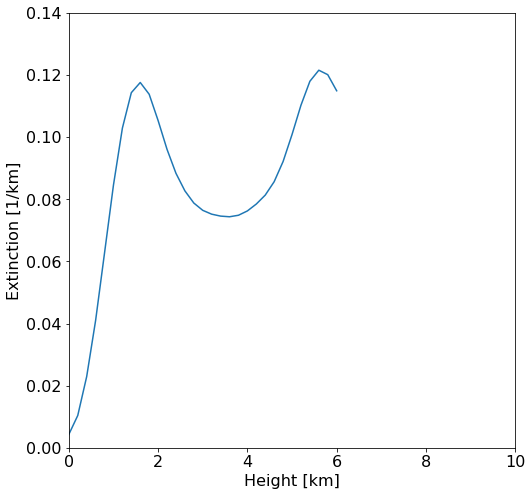

In [22]:
plt.plot(data["zgrid"], data["beta"].mean(axis=0).mean(axis=0))
plt.xlabel("Height [km]")
plt.ylabel("Extinction [1/km]")
plt.xlim(0, 10)
plt.ylim(0, 0.14)

## Overlay 3D Beta on the Carmel Map

In [4]:
def loadMapData():
    """Load height data for map visualization."""

    path1 = r"..\..\data\reconstructions\N32E034.hgt"
    path2 = r"..\..\data\reconstructions\N32E035.hgt"
    with open(path1) as hgt_data:
        hgt1 = np.fromfile(hgt_data, np.dtype('>i2')).reshape((1201, 1201))[:1200, :1200]
    with open(path2) as hgt_data:
        hgt2 = np.fromfile(hgt_data, np.dtype('>i2')).reshape((1201, 1201))[:1200, :1200]
    hgt = np.hstack((hgt1, hgt2)).astype(np.float32)
    lon, lat = np.meshgrid(np.linspace(34, 36, 2400, endpoint=False), np.linspace(32, 33, 1200, endpoint=False)[::-1])
    return lat[100:400, 1100:1400], lon[100:400, 1100:1400], hgt[100:400, 1100:1400]


def calcSeaMask(hgt_array):
    """Calc a masking to the sea.

    Note:
    This code is empirical, and should be adjusted if grid sizes change.
    """

    hgt_u8 = (255 * (hgt_array-hgt_array.min())/(hgt_array.max()-hgt_array.min())).astype(np.uint8)

    mask = (hgt_u8>7).astype(np.uint8)*255
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (16, 16))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)
    mask[250:, 250:] = 255

    return mask < 255

def convertMapData(lat, lon, hgt, lat0=32.775776, lon0=35.024963, alt0=229):
    """Convert lat/lon/height data to grid data."""

    n, e, d = pymap3d.geodetic2ned(
        lat, lon, hgt,
        lat0=lat0, lon0=lon0, h0=alt0)

    x, y, z = e, n, -d

    xi = np.linspace(-10000, 10000, 300)
    yi = np.linspace(-10000, 10000, 300)
    X, Y = np.meshgrid(xi, yi)

    Z = ml.griddata(y.flatten(), x.flatten(), z.flatten(), yi, xi, interp='linear')
    Z_mask = calcSeaMask(Z)

    return X, Y, Z, Z_mask

In [5]:
latitude, longitude, altitude = 32.775776, 35.024963, 229
lat, lon, hgt = loadMapData()

map_coords = convertMapData(
    lat,
    lon,
    hgt,
    lat0=latitude,
    lon0=longitude,
    alt0=altitude,
)

X, Y, Z, Z_mask = map_coords

In [56]:
#
# Draw the reconstruction
#
viz3D(beta, xgrid, ygrid, zgrid, export_data)

#
# Draw the map
#
mlab.surf(Y, X, Z, mask=Z_mask)

#
# Show the direction of the SUN
#
arrow_length = 1000
W = arrow_length * sun_mu
V = arrow_length * math.sin(math.acos(sun_mu)) * math.cos(sun_az)
U = arrow_length * math.sin(math.acos(sun_mu)) * math.sin(sun_az)
sun_az, sun_mu
v = mlab.pipeline.vectors(
    mlab.pipeline.vector_scatter(-U, -V, -W, U, V, W)
) #xyzuvw
v.glyph.glyph.clamping = False

mlab.show()

### Short Animation

In [ ]:
ipw_x, ipw_y, ipw_z = viz3D(beta, grid["X"].flatten(), grid["Y"].flatten(), grid["Z"].flatten(), export_data)

mlab.surf(Y, X, Z, mask=Z_mask)

for i in tqdm.tqdm_notebook(range(50)):
    mlab.savefig("test_{:03}.jpg", size=(640, 640))
    ipw_z.ipw.origin = ipw_z.ipw.origin + np.array([0, 0, 0.1])
    ipw_z.ipw.point1 = ipw_z.ipw.point1 + np.array([0, 0, 0.1])
    ipw_z.ipw.point2 = ipw_z.ipw.point2 + np.array([0, 0, 0.1])